# **Import the dependencies**

In [1]:
# data exploration and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px

# enable inline plottings
%matplotlib inline

# preprocessing
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

# feqature selection, pca, dimensionality reduction
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel, SelectKBest, VarianceThreshold, f_classif
from sklearn.decomposition import PCA

# models
from xgboost import XGBClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# fine tuning
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, train_test_split, learning_curve

# metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# saving and loading model
import joblib

# ignore the warnings
from warnings import filterwarnings
filterwarnings("ignore")

# **Data Loading and Exploration**

In [3]:
df = pd.read_csv("./mushrooms.csv")
print(df.head())

# get the data information

print("\nData Info -\n")
print(df.info())

print("\nData Description -\n")
print(df.describe())

# check for missing values
print("Missing Values -\n")
print(df.isnull().sum())

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

In [4]:
# visualize class distribution

class_counts = df["class"].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

fig = px.bar(class_counts, x='Class', y='Count', 
             title='Class Distribution',
             labels={'Class': 'Class', 'Count': 'Count'})
fig.show()

# **Data Preprocessing Function**

In [5]:
def preprocess(X, y):
    # Encode target column
    y = y.map({"e": 0, "p": 1})

    # Remove constant features (excluding target)
    constant_cols = [col for col in X.columns if X[col].nunique() == 1 and col != "class"]
    X = X.drop(columns=constant_cols)

    # Onehot encode all other categorical columns
    cat_cols = [col for col in X.columns if X[col].dtype == "object"]
    encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
    data_encoded = encoder.fit_transform(X[cat_cols])

    # Convert encoded data to DataFrame
    df_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(cat_cols))

    # Add target column to the DataFrame
    df_encoded["class"] = y.values

    # Convert to integers
    df_encoded = df_encoded.astype("int")

    return df_encoded

# **Feature Selection Function**

In [6]:
def select_features(X, y, k=19):
    selector = SelectKBest(score_func=f_classif, k=k)
    
    # Drop target column for feature selection
    X_features = X.drop(columns=["class"])
    
    # Fit selector and transform features
    X_new = selector.fit_transform(X_features, X["class"])
    
    # Extract selected feature names
    selected_feature_names = X_features.columns[selector.get_support()]
    
    # Create DataFrame with selected features and target
    final_df = pd.DataFrame(X_new, columns=selected_feature_names)
    final_df["class"] = X["class"].values
    
    return final_df

# **Pipeline for above steps**

In [7]:
preprocess_transformer = FunctionTransformer(lambda X: preprocess(X.drop(columns=["class"]), X["class"]))
feature_select_transformer = FunctionTransformer(lambda X: select_features(X, X["class"], k=19))

pipe1 = Pipeline([
    ("preprocess", preprocess_transformer),
    ("feature_selection", feature_select_transformer)
])

print("DF before preprocessing and feature selection :\n")
print(df.head())

print("\n\nDF after preprocessing and feature selection : \n")
df_transformed = pipe1.fit_transform(df)
print(df_transformed.head())

DF before preprocessing and feature selection :

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w       

# **Train Val Test Split**

In [8]:
# Split data into train and temp datasets
train_df, temp_df = train_test_split(df_transformed, test_size=0.3, random_state=42, stratify=df_transformed['class'])

# Split temp into validation and test datasets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['class'])

# Check the sizes of the datasets
print("Training set size: ", train_df.shape)
print("Validation set size: ", val_df.shape)
print("Test set size: ", test_df.shape)

Training set size:  (5686, 20)
Validation set size:  (1219, 20)
Test set size:  (1219, 20)


In [9]:
X_train, y_train = train_df.drop("class",axis=1), train_df["class"]
X_val, y_val = val_df.drop("class",axis=1), val_df["class"]
X_test, y_test = test_df.drop("class",axis=1), test_df["class"]

# **Model Training and Evaluation**

In [10]:
# Hyperparameter Tuning Function
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Training and Evaluation Function
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the validation set
    if hasattr(model, "predict_proba"):
        y_pred_val = model.predict_proba(X_val)[:, 1]  # Probability of the positive class
    else:
        y_pred_val = model.predict(X_val)
    
    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_val > 0.5).astype(int)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred_binary)
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    
    # Print evaluation metrics
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-" * 30)
    
    return model, f1

# Models and Hyperparameters to Tune
models = [
    (LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 10, 20, 30]}),
    (RandomForestClassifier(), {'n_estimators': [50, 100, 200, 300, 500]}),
    (MLPClassifier(max_iter=10000), {'hidden_layer_sizes': [(50,), (100,), (300,), (50, 50)]}),
    (LinearSVC(max_iter=10000), {'C': [0.1, 1, 10]}),
    (GaussianNB(), {}),  # Gaussian Naive Bayes has no hyperparameters to tune
    (MultinomialNB(), {'alpha': [0.1, 0.5, 1]}),
    (BernoulliNB(), {'alpha': [0.1, 0.5, 1]}),
    (XGBClassifier(), {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01], 'n_estimators': [50, 100, 200]})
]

# Train, Tune and Evaluate each model
best_model = None
best_f1_score = 0

for model, param_grid in models:
    print(f"Tuning {model.__class__.__name__}...")
    tuned_model = hyperparameter_tuning(model, param_grid, X_train, y_train)
    trained_model, f1 = train_and_evaluate_model(tuned_model, X_train, y_train, X_val, y_val)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = trained_model

# Test the Best Model
y_pred_test = best_model.predict(X_test)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print("Best Model:", best_model.__class__.__name__)
print("Test Set Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

Tuning LogisticRegression...
Model: LogisticRegression
Accuracy: 0.9779
Precision: 0.9845
Recall: 0.9694
F1 Score: 0.9769
------------------------------
Tuning DecisionTreeClassifier...
Model: DecisionTreeClassifier
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
Tuning RandomForestClassifier...
Model: RandomForestClassifier
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
Tuning MLPClassifier...
Model: MLPClassifier
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
------------------------------
Tuning LinearSVC...
Model: LinearSVC
Accuracy: 0.9737
Precision: 0.9843
Recall: 0.9609
F1 Score: 0.9725
------------------------------
Tuning GaussianNB...
Model: GaussianNB
Accuracy: 0.9155
Precision: 0.9879
Recall: 0.8350
F1 Score: 0.9051
------------------------------
Tuning MultinomialNB...
Model: MultinomialNB
Accuracy: 0.9270
Precision: 0.9883
Recall: 0.8588
F1 Score: 0.919

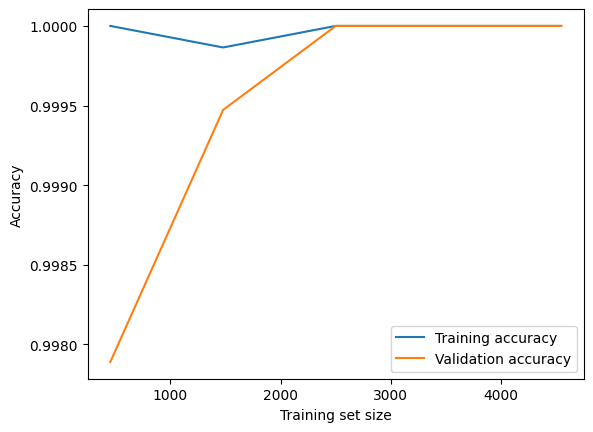

In [11]:
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training accuracy')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.legend()

# **Save the best model**

In [13]:
# Save the best model and its params to a file
joblib.dump(best_model, f'./best_model.joblib')

with open(f'./best_model_params.txt', "w") as f:
    f.write(f"{best_model.get_params()}")

print("Best model saved successfully!")

Best model saved successfully!
